# Multilingual emoji prediction project

## Import tools

In [1]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime
from sklearn.model_selection import train_test_split

PreprocessedDataFolder = "PreprocessedData"
StructuredDataFolder = "StructuredData"
SplitedDataFolder = "SplitedData"
NUMBER_EMOJI = 20
GROUP_BY_SEMANTIC = False

## Data set handler
Will be use to choose our dataset in order to test with :
* 20 emojis (all the dataset)
* 10 most used emojis
* 5 most used emojis
* Combined emojis which have the same semantics

In [2]:
class DataSetHandler :
    
    def __init__(self):
        csv_files = glob(StructuredDataFolder+'/tweets*.txt.data')
        data_list = list()
        for file in csv_files:
            file_data = pd.read_csv(file, encoding="utf_8", sep=";")
            data_list.append(file_data)
        self.data = pd.concat(data_list, axis=0, ignore_index=True)
        self.setOrder()
    
    def setOrder(self):
        unique, counts = np.unique(self.data['emoji'], return_counts=True)
        self.order = unique[np.argsort(counts)]
    
    def getTrainTest(self, name, random_state=123456, overwrite=False, train_size=0.8, test_size=0.2):
        file = f'{SplitedDataFolder}/{name}_splits_{random_state}.json'
        os.makedirs(os.path.dirname(file), exist_ok=True)
        if not overwrite and glob(file):
            with open(file, 'r') as f:
                idx = json.load(f)
            train = self.data.loc[[int(x) for x in idx['train']],:]
            test = self.data.loc[[int(x) for x in idx['test']],:]
        else:
            train, test = train_test_split(
                self.data,
                train_size=train_size,
                test_size=test_size,
                random_state=random_state,
                shuffle=True)
            with open(file, 'w') as f:
                json.dump({'train': train.index.to_list(), 'test': test.index.to_list()}, f)
        return train, test
        
    # Split most used emojis
    def setMostUsedEmojis(self, number=20):
        self.data = self.data[self.data['emoji'].isin(self.order[-min(number, len(np.unique(self.data['emoji']))):])]
    
    # Choosed semantic groups :
    # 0 : ❤:0 | 💕:3 | 💙:8 | 💜:13
    # 1 : 😍:1 | 😘:9
    # 2 : 📷:10 | 📸:18
    # 3 : 😂:2
    # 4 : 🔥:4
    # 5 : 😊:5
    # 6 : 😎:6
    # 7 : ✨:7
    # 8 : 🇺🇸: 11
    # 9 : ☀:12
    # 10 : 😉:14
    # 11 : 💯:15
    # 12 : 😁:16
    # 13 : 🎄:17
    # 14 : 😜:19
    def getMappingForGroupBySemantic(self):
        return {
            0: 0,
            1: 1,
            2: 3,
            3: 0,
            4: 4,
            5: 5,
            6: 6,
            7: 7,
            8: 0,
            9: 1,
            10: 2,
            11: 8,
            12: 9,
            13: 0,
            14: 10,
            15: 11,
            16:  12,
            17:  13,
            18:  2,
            19:  14,
        }
    
    #change the self.data dataset to merging some emojis together
    def setSemanticCombinedEmojis(self):
        mapping = self.getMappingForGroupBySemantic()
        self.data['emoji'] = [mapping[x] for x in self.data['emoji']]
        self.setOrder()

    def add_datetime(self):
        self.data['creation_date_datetime'] = [datetime.strptime(date, '%a %b %d %H:%M:%S %z %Y') for date in self.data['created_at']]
        self.data['month'] = [date.month for date in self.data['creation_date_datetime']]
    
    def add_christmas(self):
        self.data['christmas'] = [1 if month in [11,12,1] else 0 for month in self.data['month']]
    
    # Do not use, no tweet at Valentin's day
    def add_valentine(self):
        self.data['valentine'] = [date.day == 14 and date.month == 2 for date in self.data['creation_date_datetime']]
        
    def add_summer(self):
        self.data['summer'] = [1 if date.month in [6,7,8] else 0 for date in self.data['creation_date_datetime']]
    
    def add_char_number(self, char):
        self.data[f'number_{char}'] = [sum([char == x for x in text]) for text in self.data['text']]
    
dataSetHand = DataSetHandler()

## Data Visualization

### Distribution

In [3]:
_, counts = np.unique(dataSetHand.data['emoji'], return_counts=True)
plt.bar(range(max(dataSetHand.data['emoji'])+1), counts)
plt.show()

### Combine emojis in classes by semantic


In [4]:
%%time
dataSetHand.add_datetime()
dataSetHand.add_christmas()#is it in christmas period ?
dataSetHand.add_summer()#is it in summer period ?
dataSetHand.add_char_number('!')#How many '!' ?
dataSetHand.add_char_number('?')#How many '?' ?
dataSetHand.add_char_number('#')#How many '#' ?
dataSetHand.add_char_number('@')#How many '@' ?
if GROUP_BY_SEMANTIC : 
    dataSetHand.setSemanticCombinedEmojis()

Wall time: 21.4 s


### Semantic combined classes distribution

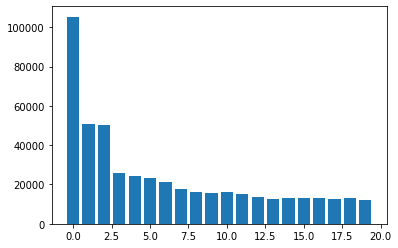

In [5]:
_, counts = np.unique(dataSetHand.data['emoji'], return_counts=True)
plt.bar(range(max(dataSetHand.data['emoji'])+1), counts)
plt.show()

### Visualization on added features

#### Visualization functions

In [6]:
# Show given emoji percentage per month
def emojiPercentageMonth(emoji):
    emoji_month = [sum([x == emoji for x in dataSetHand.data[dataSetHand.data['month'] == month]['emoji']]) / len(dataSetHand.data[dataSetHand.data['month'] == month].index) for month in range(1,13)]
    plt.bar(range(1,13), emoji_month)
    plt.show()
    
# Number of emoji (by type) in given month
def numberEmojiMonth(month):
    monthDataFrame = dataSetHand.data[[date.month == month for date in dataSetHand.data['creation_date_datetime']]]
    _, counts = np.unique(monthDataFrame['emoji'], return_counts=True)
    plt.bar(range(np.unique(monthDataFrame['emoji']).size), counts)
    plt.show()

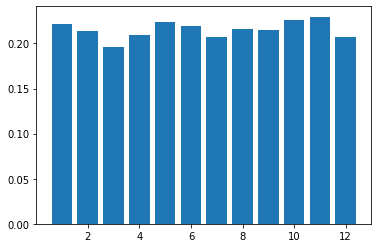

In [7]:
# Hearts percentage per month
emojiPercentageMonth(0)

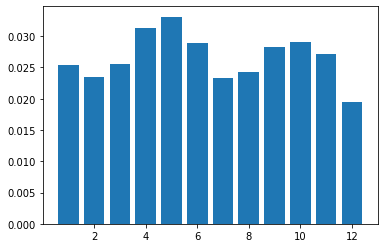

In [8]:
# Saplin percentage per month
emojiPercentageMonth(13)

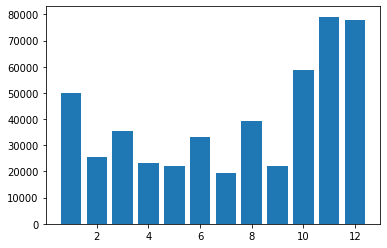

In [9]:
# Number of tweets per month
tweet_month = [len(dataSetHand.data[dataSetHand.data['month'] == month].index) for month in range(1,13)]
plt.bar(range(1,13), tweet_month)
plt.show()

In [10]:
# Missing tweets at valenti's day
feb = dataSetHand.data[[date.month == 2 for date in dataSetHand.data['creation_date_datetime']]]
np.unique([date.day for date in feb['creation_date_datetime']])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29])

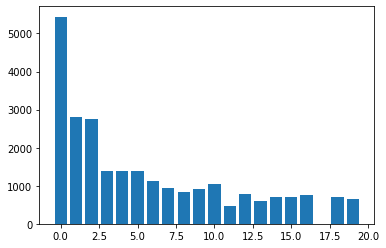

In [11]:
# Number of emoji (by type) in February
numberEmojiMonth(2)

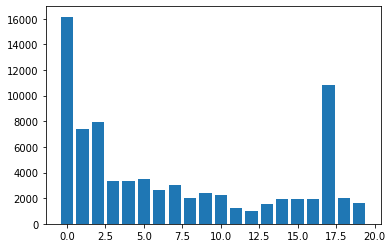

In [12]:
# Number of emoji (by type) in December
numberEmojiMonth(12)

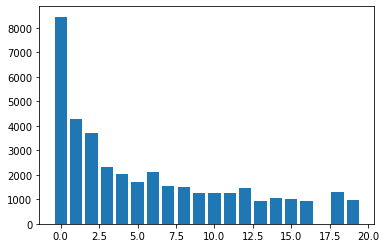

In [13]:
# Number of emoji (by type) in August
numberEmojiMonth(8)

## Preprocess the text

In [14]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk.stem
from nltk import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import csr_matrix
import re
import itertools

nltk.download('stopwords')
nltk.download('punkt')#stemm
nltk.download('wordnet')#lemmatize
nltk.download('averaged_perceptron_tagger')#pos tag


class PreprocessorText:
    
    def __init__(self):
        self.pipeline = [self.lowerCaser,self.hashTagRemover,self.userMentionRemover, self.underscoreRemover, word_tokenize, self.startWithNumberRemover, self.removeStopWords, self.removeDuplicateCharFollowing, self.stemmatize, self.removeOneCharOrEmptyWord]
        self.lemmatizer = WordNetLemmatizer()
        self.ps = PorterStemmer()
        self.stopwords = set(stopwords.words('english'))      
 
    #----------------------------------- Apply on sentence
    
    """
    @:input the sentence to preprocess
    @:returns preprocessed sentence
    """
    def process(self,text : str)-> [str] : 
        for f in self.pipeline:
            text = f(text)
        #at this instant, text is of type [str] (because of wordtokenizer),
        #where str is each word of the sentence
        return " ".join(text) 
    def transform(self,text : [str])-> csr_matrix:
        prepro = ["" for _ in range(len(text))]
        for i in range(len(text)):
            prepro[i] = self.process(text[i])
        return prepro
 
    def lowerCaser(self, text: str)->str:
        return text.lower()
    
    def hashTagRemover(self,text : str) ->str:
        return re.sub('#[^\s]*', '', text)
    
    def userMentionRemover(self,text : str) ->str:
        return re.sub('@[^\s]*', '', text)
   
      #remove _ at the beginning
    def underscoreRemover(self,text : str)-> str:
        return re.sub('_', '', text)
    
    #----------------Apply on list of words
    
    
    #remove numbers at the beginning
    def startWithNumberRemover(self,text : [str])-> [str]:
        return [re.sub('[0-9]', '', t).strip() for t in text]
 
    
    
    def stemmatize(self,text : [str])-> [str]:
        return [self.ps.stem(w) for w in text]
    def lemmatize(self,text : [str])-> [str]:
        return [self.lemmatizer.lemmatize(w) for w in text]
    def removeOneCharOrEmptyWord(self,text : [str])->[str]:
        return list(filter(lambda x : len(x)>1,text))
    
    """
    txt = ['abbbdfd', 'abcde', 'aaaabbbbbcdddde']
    removeDuplicateCharFollowing(txt)
    Out: ['abbdfd', 'abcde', 'aabbcdde']
    """
    def removeDuplicateCharFollowing(self,text : [str])-> [str]:
        return [''.join(ch if sum(1 for _ in nb)==1 else ch+ch for ch,nb in itertools.groupby(t)) for t in text]
        
    
    """
    @:returns a list of couple (word, tag)
    """
    def tagPos(self,text : list) ->list:
        return nltk.pos_tag(text)
    def removeStopWords(self, text : list)-> list:
        return list(filter(lambda w : not (w in self.stopwords),text))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\willi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\willi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\willi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\willi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Examples
Initiliaze the preprocessor : 

In [15]:
prepro = PreprocessorText()

#example
examples_train_set = ["Hello you","It's sunny in the sky","I'm washing the dirty floor","hello I'm washing the lovely floor"]
examples_train_set_processed = prepro.transform(examples_train_set)
examples_train_set_processed

['hello', "'s sunni sky", "'m wash dirti floor", "hello 'm wash love floor"]

#### Preprocess the database

In [16]:
dataSetHand.setMostUsedEmojis(NUMBER_EMOJI)

In [17]:
%%time
## Train and test sets instantiation
dataTrain, dataTest = dataSetHand.getTrainTest('test')

Wall time: 808 ms


In [18]:
dataTrain.shape

(388577, 22)

In [19]:
dataTest.shape

(97145, 22)

In [20]:
%%time
prepro = PreprocessorText()
preprocessed_data = prepro.transform(dataTrain["text"].values)
pd.DataFrame(preprocessed_data[:3])

Wall time: 2min 4s


0
0  umm welcom goldman hous chao sometim take
1            long point trail new river gorg
2        littl bit everyth lot noth bro agre

In [21]:
%%time
prepro = PreprocessorText()
preprocessed_data_test = prepro.transform(dataTest["text"].values)
pd.DataFrame(preprocessed_data_test[:3])

Wall time: 31.2 s


0
0  beef heart tartar fish sauc chili puf rice radish
1  sometim go stand outsid someon ask us peopl sa...
2  good night nation capit washington district co...

In [22]:
%%time
trainFile = PreprocessedDataFolder+"/train.prepro"
testFile = PreprocessedDataFolder+"/test.prepro"
os.makedirs(os.path.dirname(trainFile), exist_ok=True)
os.makedirs(os.path.dirname(testFile), exist_ok=True)


with open(trainFile, 'w', encoding="utf_8") as f:
    for item in preprocessed_data:
        f.write("%s\n" % item)
with open(testFile, 'w', encoding="utf_8") as f:
    for item in preprocessed_data_test:
        f.write("%s\n" % item)

Wall time: 492 ms


In [23]:
trainFile = PreprocessedDataFolder+"/train.emojis"
testFile = PreprocessedDataFolder+"/test.emojis"
ytrain = dataTrain.emoji
ytest = dataTest.emoji
with open(trainFile, 'w', encoding="utf_8") as f:
    for item in ytrain:
        f.write("%s\n" % item)
with open(testFile, 'w', encoding="utf_8") as f:
    for item in ytest:
        f.write("%s\n" % item)

In [24]:
class FeatureExporter: 
    def __init__(self,initDataNotPreprocessed):
        self.featuresToAdd = ["month","christmas","summer","number_#","number_@","number_!","number_?"]
        self.initDataNotPreprocessed = initDataNotPreprocessed

    #data : in out
    def exportAllFeatures(self,fileName):
        df = self.initDataNotPreprocessed[["month","christmas","summer","number_#","number_@","number_!","number_?"]]
        df.to_csv(fileName)

In [25]:
trainFile = PreprocessedDataFolder+"/train.addFeatures"
testFile = PreprocessedDataFolder+"/test.addFeatures"

FeatureExporter(dataTrain).exportAllFeatures(trainFile)
FeatureExporter(dataTest).exportAllFeatures(testFile)